In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [01:43<00:00, 24.6MB/s]
100% 2.29G/2.29G [01:43<00:00, 23.8MB/s]
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
100% 662M/663M [00:31<00:00, 20.3MB/s]
100% 663M/663M [00:31<00:00, 22.1MB/s]


In [2]:
!unzip chest-xray-pneumonia.zip &> /dev/null
!unzip tuberculosis-tb-chest-xray-dataset.zip &> /dev/null

In [3]:
 !mv ./TB_Chest_Radiography_Database/Normal ./TB_Chest_Radiography_Database/NORMAL

In [4]:
!mv ./TB_Chest_Radiography_Database/Tuberculosis ./TB_Chest_Radiography_Database/TUBERCULOSIS

In [5]:
!rm ./TB_Chest_Radiography_Database/Normal.metadata.xlsx ./TB_Chest_Radiography_Database/README.md.txt ./TB_Chest_Radiography_Database/Tuberculosis.metadata.xlsx

In [6]:
data_chestxray_dir = "./chest_xray/chest_xray/"
data_chesttb_dir = "./TB_Chest_Radiography_Database/"

In [7]:
import os
import shutil
import random

# Paths to the original folders
classes_tbchest = ['NORMAL', 'TUBERCULOSIS']

# Paths for the new folders
base_dir_tbchest = 'chest_tb'
train_dir = os.path.join(base_dir_tbchest, 'train')
val_dir = os.path.join(base_dir_tbchest, 'val')
test_dir = os.path.join(base_dir_tbchest, 'test')

# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for cls in classes_tbchest:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

# Split ratio
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Function to split data
def split_data(class_dir, train_dir, val_dir, test_dir):
    files = os.listdir(class_dir)
    random.shuffle(files)

    train_size = int(len(files) * train_ratio)
    val_size = int(len(files) * val_ratio)

    train_files = files[:train_size]
    val_files = files[train_size:train_size + val_size]
    test_files = files[train_size + val_size:]

    for file in train_files:
        shutil.copy(os.path.join(class_dir, file), os.path.join(train_dir, file))

    for file in val_files:
        shutil.copy(os.path.join(class_dir, file), os.path.join(val_dir, file))

    for file in test_files:
        shutil.copy(os.path.join(class_dir, file), os.path.join(test_dir, file))

# Split each class
for cls in classes_tbchest:
    class_dir = os.path.join(data_chesttb_dir, cls)
    split_data(class_dir, os.path.join(train_dir, cls), os.path.join(val_dir, cls), os.path.join(test_dir, cls))

print("Dataset split completed!")

Dataset split completed!


In [8]:
data_chesttb_dir = "./chest_tb/"

In [9]:
from typing import Union

import torchvision.transforms as T
from PIL.Image import Image
from torch import Tensor
from typing import List, Optional, Tuple, Union


class SimCLRViewTransform:
    def __init__(
        self,
        image_size: int = 224,
        color_jitter_strength: float = 1,
        use_blur: bool = True,
        mean: Tuple[float, Optional[float], Optional[float]] = (0.485, 0.456, 0.406),
        std: Tuple[float, Optional[float], Optional[float]] = (0.229, 0.224, 0.225),
        **kwargs,
    ):
        self.image_size = image_size
        self.color_jitter_strength = color_jitter_strength
        self.use_blur = use_blur
        self.mean = mean
        self.std = std
        self.transform = T.Compose(
            [
                T.RandomResizedCrop(image_size, antialias=True),
                T.RandomHorizontalFlip(p=0.5),
                T.RandomApply(
                    [
                        T.ColorJitter(
                            0.8 * self.color_jitter_strength,
                            0.8 * self.color_jitter_strength,
                            0.8 * self.color_jitter_strength,
                            0.2 * self.color_jitter_strength,
                        )
                    ],
                    p=0.8,
                ),
                T.RandomGrayscale(p=0.2),
                T.RandomApply(
                    [
                        T.GaussianBlur(
                            kernel_size=image_size // 20 * 2 + 1, sigma=(0.1, 2.0)
                        )
                    ],
                    p=0.5 if self.use_blur else 0.0,
                ),
                T.Normalize(mean=mean, std=std),
            ]
        )

    def __call__(self, image: Union[Tensor, Image]) -> Tensor:
        return self.transform(image)

In [10]:
import os
from PIL import Image
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms


def data_transforms(phase):
    # If the phase is TRAIN
    if phase == 'train':
        # Compose transformations: Convert to Tensor
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])

    # If the phase is VAL
    if phase == 'val':
        # Apply the same transformations as the TRAIN phase
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    # If the phase is TEST
    if phase == 'test':
        # Apply the same transformations as the TRAIN phase
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    return transform  # Return the composed transformations

image_datasets_chestxray = {x: datasets.ImageFolder(os.path.join(data_chestxray_dir, x), data_transforms(x)) for x in ['train', 'val', 'test']}
image_datasets_chesttb = {x: datasets.ImageFolder(os.path.join(data_chesttb_dir, x), data_transforms(x)) for x in ['train', 'val', 'test']}

new_class_to_idx_tb = {'NORMAL': 0, 'TUBERCULOSIS': 2}

# Function to remap the labels in a dataset
def remap_labels(dataset, new_class_to_idx):
    # Remap the targets
    dataset.targets = [new_class_to_idx[dataset.classes[label]] for label in dataset.targets]

    # Update class index in dataset.samples
    new_samples = []
    for path, label in dataset.samples:
        new_samples.append((path, new_class_to_idx[dataset.classes[label]]))
    dataset.samples = new_samples

    # Update the class_to_idx attribute
    dataset.class_to_idx = new_class_to_idx
    # Update the classes attribute
    dataset.classes = list(new_class_to_idx.keys())

# Apply the remapping to the chesttb datasets
for phase in ['train', 'val', 'test']:
    remap_labels(image_datasets_chesttb[phase], new_class_to_idx_tb)

In [11]:
print(image_datasets_chestxray['train'].class_to_idx)
print(len(image_datasets_chestxray['train']))

print(np.unique(image_datasets_chestxray['train'].targets, return_counts=True))

{'NORMAL': 0, 'PNEUMONIA': 1}
5216
(array([0, 1]), array([1341, 3875]))


In [12]:
print(image_datasets_chesttb['train'].class_to_idx)
print(len(image_datasets_chesttb['train']))

print(np.unique(image_datasets_chesttb['train'].targets, return_counts=True))

{'NORMAL': 0, 'TUBERCULOSIS': 2}
2939
(array([0, 2]), array([2450,  489]))


In [13]:
# Combine the datasets after remapping
image_datasets_combined = {
    x: torch.utils.data.ConcatDataset([image_datasets_chestxray[x], image_datasets_chesttb[x]])
    for x in ['train', 'val', 'test']
}

In [14]:
targets_combined = []

for dataset in image_datasets_combined['train'].datasets:
    targets_combined.extend(dataset.targets)

targets_combined = torch.tensor(targets_combined)

# Calculate class weights (inverse of class frequency)
class_counts = torch.bincount(targets_combined)
class_weights = 1.0 / class_counts.float()
print(f"Class weights: {class_weights}")

# Calculate sample weights based on class weights
sample_weights = class_weights[targets_combined]
print(f"Sample weights: {sample_weights}")

# Create WeightedRandomSampler
sampler = torch.utils.data.WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

Class weights: tensor([0.0003, 0.0003, 0.0020])
Sample weights: tensor([0.0003, 0.0003, 0.0003,  ..., 0.0020, 0.0020, 0.0020])


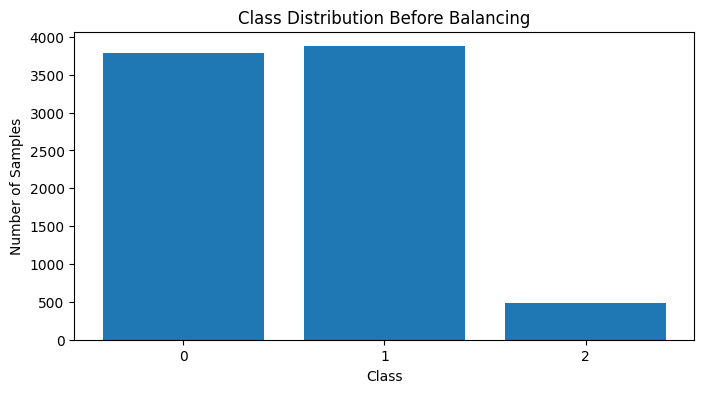

Class counts before balancing: [3791 3875  489]


In [15]:
import matplotlib.pyplot as plt

# Count the number of instances of each class before balancing
class_counts = torch.bincount(targets_combined)

# Plot the class distribution
plt.figure(figsize=(8, 4))
plt.bar(range(len(class_counts)), class_counts.numpy(), tick_label=list(range(len(class_counts))))
plt.title("Class Distribution Before Balancing")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

print("Class counts before balancing:", class_counts.numpy())

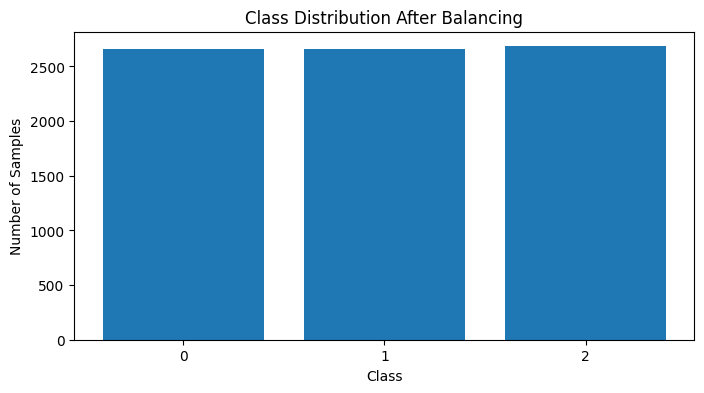

Class counts after balancing: [2657 2659 2684]


In [16]:
# Simulate sampling
num_samples_to_check = 8000  # You can increase this number for better accuracy
sampled_indices = list(sampler)[:num_samples_to_check]
sampled_targets = targets_combined[sampled_indices]

# Count the number of instances of each class after balancing
balanced_class_counts = torch.bincount(sampled_targets)

# Plot the class distribution after balancing
plt.figure(figsize=(8, 4))
plt.bar(range(len(balanced_class_counts)), balanced_class_counts.numpy(), tick_label=list(range(len(balanced_class_counts))))
plt.title("Class Distribution After Balancing")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

print("Class counts after balancing:", balanced_class_counts.numpy())

In [17]:
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets_combined['train'], batch_size = 32, sampler=sampler),
    'val': torch.utils.data.DataLoader(image_datasets_combined['val'], batch_size = 32),
    'test': torch.utils.data.DataLoader(image_datasets_combined['test'], batch_size = 32)
}

In [18]:
# # Check class distribution in your training set
# targets = []
# for _, labels in dataloaders['train']:
#     targets.extend(labels.cpu().numpy())
# print("Class distribution:", np.bincount(targets))

In [19]:
len(dataloaders['train'])

255

In [20]:
class NT_Xent(nn.Module):
    def __init__(self, temperature: float = 0.5, **kwargs):
        super().__init__()
        self.temperature = temperature
        self.eps = 1e-8
        if abs(self.temperature) < self.eps:
            raise ValueError(
                "Illegal temperature: abs({}) < 1e-8".format(self.temperature)
            )

    def forward(self, out0: torch.Tensor, out1: torch.Tensor):
        device = out0.device
        batch_size, _ = out0.shape

        out0 = nn.functional.normalize(out0, dim=1)
        out1 = nn.functional.normalize(out1, dim=1)

        out = torch.cat((out0, out1), dim=0)
        sim_matrix = torch.exp(torch.mm(out, out.t().contiguous()) / self.temperature)
        mask = (
            torch.ones_like(sim_matrix) - torch.eye(2 * batch_size, device=device)
        ).bool()
        sim_matrix = sim_matrix.masked_select(mask).view(2 * batch_size, -1)
        pos_sim = torch.exp(torch.sum(out0 * out1, dim=-1) / self.temperature)
        pos_sim = torch.cat((pos_sim, pos_sim), dim=0)
        loss = (-torch.log(pos_sim / sim_matrix.sum(dim=-1))).mean()
        return loss

In [21]:
class SimCLR(nn.Module):

    def __init__(
        self,
        backbone: nn.Module,
        feature_size: int,
        projection_dim: int = 128,
        **kwargs
    ):
        super().__init__()
        self.feature_size = feature_size
        self.projection_dim = projection_dim
        self.backbone = backbone

        self.projection_head = nn.Sequential(
            nn.Sequential(nn.Linear(self.feature_size, self.feature_size), nn.BatchNorm1d(self.feature_size), nn.ReLU(inplace=True)),
            nn.Sequential(nn.Linear(self.feature_size, self.feature_size), nn.BatchNorm1d(self.feature_size), nn.ReLU(inplace=True)),
            nn.Sequential(nn.Linear(self.feature_size, self.feature_size), nn.BatchNorm1d(self.feature_size)))

        self.encoder = nn.Sequential(self.backbone, self.projection_head)

    def forward(self, x0: torch.Tensor, x1: torch.Tensor):
        f0 = self.backbone(x0).flatten(start_dim=1)
        out0 = self.projection_head(f0)

        f1 = self.backbone(x1).flatten(start_dim=1)
        out1 = self.projection_head(f1)

        return out0, out1

In [22]:
backbone = models.resnet50()
num_features = backbone.fc.in_features
backbone.fc = nn.Identity()

model = SimCLR(backbone=backbone, feature_size=num_features, projection_dim=128)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [23]:
print(f"Number of Model Parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Memmory Usage: {torch.cuda.memory_allocated(device) / 1024**3:.2f} GB")

Number of Model Parameters: 36109376
Memmory Usage: 0.13 GB


In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = NT_Xent()
ssl_transform = SimCLRViewTransform()

### SSL Training

In [25]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Initialize dictionaries to store metrics
metrics = {
    'train_loss': [],
    'val_loss': [],
}

# Parameters for Early Stopping
early_stopping_patience = 5  # Stop after 5 epochs with no improvement
best_val_loss = float('inf')
patience_counter = 0

num_epochs = 100  # Set a higher number of epochs to allow early stopping

model.load_state_dict(torch.load('/content/drive/MyDrive/model_ssl_epoch_90.pth'))

for epoch in range(90,num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
            dataloader = dataloaders['train']
        else:
            model.eval()  # Set model to evaluate mode
            dataloader = dataloaders['val']

        running_loss = 0.0
        running_corrects = 0
        all_labels = []
        all_preds = []

        # Iterate over data with tqdm progress bar
        for inputs, _ in tqdm(dataloader, desc=f"{phase.capitalize()} Phase"):
            inputs = inputs.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            aug1 = ssl_transform(inputs)
            aug2 = ssl_transform(inputs)

            # Forward pass
            with torch.set_grad_enabled(phase == 'train'):
                out0, out1 = model(aug1, aug2)
                loss = criterion(out0, out1)

                # Backward pass + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)

        # Calculate metrics
        epoch_loss = running_loss / len(dataloader.dataset)

        # Save metrics
        metrics[f'{phase}_loss'].append(epoch_loss)

        print(f'{phase.capitalize()} Loss: {epoch_loss:.4f}')

        # Early stopping check during validation phase
        if phase == 'val':
            if epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                patience_counter = 0  # Reset the counter if improvement occurs
                # Save the model weights when improvement occurs
                torch.save(model.state_dict(), '/content/drive/MyDrive/best_model_ssl_training.pth')
            else:
                patience_counter += 1

        if epoch % 10 == 0:
            # Save the model weights every 10 epochs
            torch.save(model.state_dict(), f'/content/drive/MyDrive/model_ssl_epoch_{epoch}.pth')

    print()

    # # Check for early stopping
    # if patience_counter >= early_stopping_patience:
    #     print("Early stopping triggered")
    #     break

# Specify the path to save the file in Google Drive
output_path = "/content/drive/MyDrive/training_metrics_ssl_training.txt"
with open(output_path, "w") as f:
    for key, values in metrics.items():
        f.write(f"{key}: {values}\n")

print(f"Training metrics saved to {output_path}")

Mounted at /content/drive
Epoch 91/100
----------


Train Phase: 100%|██████████| 255/255 [04:46<00:00,  1.12s/it]


Train Loss: 2.4138


Val Phase: 100%|██████████| 21/21 [00:12<00:00,  1.69it/s]


Val Loss: 4.1681

Epoch 92/100
----------


Train Phase: 100%|██████████| 255/255 [04:47<00:00,  1.13s/it]


Train Loss: 2.4307


Val Phase: 100%|██████████| 21/21 [00:12<00:00,  1.71it/s]


Val Loss: 4.3785

Epoch 93/100
----------


Train Phase: 100%|██████████| 255/255 [04:46<00:00,  1.12s/it]


Train Loss: 2.4266


Val Phase: 100%|██████████| 21/21 [00:11<00:00,  1.80it/s]


Val Loss: 4.3002

Epoch 94/100
----------


Train Phase: 100%|██████████| 255/255 [04:44<00:00,  1.12s/it]


Train Loss: 2.4200


Val Phase: 100%|██████████| 21/21 [00:11<00:00,  1.80it/s]


Val Loss: 4.4260

Epoch 95/100
----------


Train Phase: 100%|██████████| 255/255 [04:45<00:00,  1.12s/it]


Train Loss: 2.4004


Val Phase: 100%|██████████| 21/21 [00:11<00:00,  1.78it/s]


Val Loss: 4.2834

Epoch 96/100
----------


Train Phase: 100%|██████████| 255/255 [04:44<00:00,  1.11s/it]


Train Loss: 2.3954


Val Phase: 100%|██████████| 21/21 [00:11<00:00,  1.80it/s]


Val Loss: 4.2442

Epoch 97/100
----------


Train Phase: 100%|██████████| 255/255 [04:43<00:00,  1.11s/it]


Train Loss: 2.4250


Val Phase: 100%|██████████| 21/21 [00:12<00:00,  1.73it/s]


Val Loss: 4.2709

Epoch 98/100
----------


Train Phase: 100%|██████████| 255/255 [04:42<00:00,  1.11s/it]


Train Loss: 2.4084


Val Phase: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


Val Loss: 4.2550

Epoch 99/100
----------


Train Phase: 100%|██████████| 255/255 [04:43<00:00,  1.11s/it]


Train Loss: 2.4293


Val Phase: 100%|██████████| 21/21 [00:12<00:00,  1.74it/s]


Val Loss: 4.2182

Epoch 100/100
----------


Train Phase: 100%|██████████| 255/255 [04:42<00:00,  1.11s/it]


Train Loss: 2.4135


Val Phase: 100%|██████████| 21/21 [00:12<00:00,  1.73it/s]

Val Loss: 4.3330

Training metrics saved to /content/drive/MyDrive/training_metrics_ssl_training.txt


In [26]:
# Freeze the backbone
for param in model.backbone.parameters():
  param.requires_grad = False

# Replace the backbone's classifier with a new linear layer
num_classes = 3  # Number of classes in your dataset
model.backbone.fc = nn.Linear(num_features, num_classes)
model = model.backbone.to(device)

# Define loss function and optimizer for the linear classifier
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

# Evaluation loop
num_epochs_linear = 10  # Adjust as needed

for epoch in range(num_epochs_linear):
  model.train()
  running_loss = 0.0
  running_corrects = 0

  for inputs, labels in tqdm(dataloaders['train'], desc=f"Linear Eval Epoch {epoch+1}"):
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)

  epoch_loss = running_loss / len(dataloaders['train'].dataset)
  epoch_acc = running_corrects.double() / len(dataloaders['train'].dataset)

  print(f"Linear Eval Epoch {epoch+1} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

# Validation on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
  for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Calculate evaluation metrics
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Test Set - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


Linear Eval Epoch 1: 100%|██████████| 255/255 [02:21<00:00,  1.80it/s]


Linear Eval Epoch 1 Loss: 0.3033 Acc: 0.9084


Linear Eval Epoch 2: 100%|██████████| 255/255 [02:23<00:00,  1.78it/s]


Linear Eval Epoch 2 Loss: 0.1773 Acc: 0.9334


Linear Eval Epoch 3: 100%|██████████| 255/255 [02:21<00:00,  1.81it/s]


Linear Eval Epoch 3 Loss: 0.1624 Acc: 0.9413


Linear Eval Epoch 4: 100%|██████████| 255/255 [02:22<00:00,  1.79it/s]


Linear Eval Epoch 4 Loss: 0.1460 Acc: 0.9448


Linear Eval Epoch 5: 100%|██████████| 255/255 [02:21<00:00,  1.80it/s]


Linear Eval Epoch 5 Loss: 0.1400 Acc: 0.9471


Linear Eval Epoch 6: 100%|██████████| 255/255 [02:21<00:00,  1.80it/s]


Linear Eval Epoch 6 Loss: 0.1326 Acc: 0.9523


Linear Eval Epoch 7: 100%|██████████| 255/255 [02:22<00:00,  1.79it/s]


Linear Eval Epoch 7 Loss: 0.1365 Acc: 0.9480


Linear Eval Epoch 8: 100%|██████████| 255/255 [02:22<00:00,  1.79it/s]


Linear Eval Epoch 8 Loss: 0.1423 Acc: 0.9476


Linear Eval Epoch 9: 100%|██████████| 255/255 [02:20<00:00,  1.81it/s]


Linear Eval Epoch 9 Loss: 0.1241 Acc: 0.9548


Linear Eval Epoch 10: 100%|██████████| 255/255 [02:21<00:00,  1.81it/s]


Linear Eval Epoch 10 Loss: 0.1315 Acc: 0.9512
Test Set - Precision: 0.3616, Recall: 0.3359, F1-Score: 0.0571


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
